# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [672]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
import pickle
import math

#Set random seed
np.random.seed(1606)

### Functions

In [673]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

### 1. Import Vectors and Pre-Process them

In [674]:
# Import Gofunc vec file
with open('go-gofuncs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [675]:
df.head()

,ID,Vector
0,MESH:D012559,"[1.76247600e-02, -1.05403718e-02, -4.61959302e..."
1,MESH:D009404,"[0.01795662, 0.13640046, 0.03051887, -0.100085..."
2,MESH:D001749,"[-8.68742093e-02, 8.83234814e-02, -2.54237115e..."
3,MESH:D011471,"[-0.00926186, 0.04098112, -0.4911138, -0.22025..."
4,MESH:D008106,"[-0.12722802, 0.07976454, -0.5775048, -0.28237..."


### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [676]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID
0,C112297,MESH:D006948
1,C112297,MESH:D012640
2,C425777,MESH:D006948
3,C013567,MESH:D006333
4,C418863,MESH:D013262


In [677]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [678]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df.copy()
df_d.columns= ['DiseaseID', 'DVec']
df_c = df.copy()
df_c.columns= ['ChemicalID', 'CVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

df1['Correlation'] = 1 # currently only have correlated in there

In [679]:
df1.head()

,ChemicalID,DiseaseID,DVec,CVec,Correlation
0,C028474,MESH:D006528,"[-0.08689959, 0.06080057, -0.04620415, -0.1237...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
1,C028474,MESH:D005355,"[-4.32693306e-03, 1.35906458e-01, -1.91942360e...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
2,C028474,MESH:D006529,"[-0.02542116, 0.0981225, -0.01938446, -0.14929...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
3,C028474,MESH:D006965,"[-0.01135238, 0.143319, 0.04601676, -0.1474806...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1
4,C028474,MESH:D008114,"[-0.10265561, 0.03210206, -0.13152453, -0.0728...","[0.01018825, 0.08274926, 0.05085841, -0.117527...",1


In [680]:
len(id_list)

3137

In [681]:
chem_dis.shape

(8651, 2)

In [682]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [683]:
# Add unrelated pairs to df1
no_rows = (df1.shape[0]-1)   # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print('shape: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
    chem, chemvec = df_chems.loc[int1, 'ID'], df_chems.loc[int1, 'Vector']
    dis, disvec = df_dis.loc[int2, 'ID'], df_dis.loc[int2, 'Vector']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'CVec':chemvec, 'DVec':disvec, 'Correlation':0}, ignore_index=True)

print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)

shape:  8650
(17301, 5)
(17145, 5)


In [684]:
# Convert the elements of the vectors to actual numbers
df1['DVec'] = df1.DVec.map(lambda x: [float(i) for i in x])
df1['CVec'] = df1.CVec.map(lambda x: [float(i) for i in x])

### Add Phenotype Vecs
Got a list of Chem-Phenotypes from Sara Alth, where did these come from originally?
They have CID identifiers (Pubchem). Need to convert CTD ID to CID ID
Use API like so 
http://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sourceid/Comparative%20Toxicogenomics%20Database/C533207/cids/TXT/

In [685]:
# ## First we'll add DOIDs for diseases and CIDs for chemicals as an intermediate for adding phenotypes
# # Read in CSV mapping chems to CID and dis to DOID --> This file is created by phens-opa2vec.ipynb
# mapper = pd.read_csv('entities.lst')

# # Make the maps from this
# dis_map = dict(zip(mapper.ID, mapper.DOID))
# chem_map = dict(zip(mapper.ID, mapper.CID))

# # Apply the maps to df1
# df1['DOID'] = df1.DiseaseID.map(lambda x: dis_map.get(x))
# df1['CID'] = df1.ChemicalID.map(lambda x: chem_map.get(x))

In [686]:
# # Read in the association files from Sara
# dis_phens = pd.read_csv('Disease-PhenotypeAssocation.txt', sep=' ', names=['DOID', 'Phenotype'])
# chem_phens =  pd.read_csv('Drug-PhenotypeAssocation.txt', sep=' ', names=['CID', 'Phenotype'])

In [687]:
# # The association files have a different format for each ID system than mine, homogenise these
# # first chem
# def cid_standardiser (cid):
#     # Must be format CID + 9 int chars, starting with 1 seemingly
#     cid = int(cid)
#     output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
#     return output

# df1['CID'] = df1.CID.map(lambda x: np.nan if math.isnan(x) else cid_standardiser(x))

In [688]:
# # and now disease 
# def doid_standardiser (doid):
#     # Must be format DOID_ + ...
#     # I'm unsure about how well this is working so print out the DOIDs that don't match
#     doid = doid.replace(':', '_')
# #     output = 'CID1' + '0' * (8 - len(str(cid))) + str(cid)
#     return doid

# df1['DOID'] = df1.DOID.map(lambda x: np.nan if isinstance(x, float) else doid_standardiser(x))

In [689]:
## Now that the DOIDs and CIDs are theoretically standardised we can chuck in the phens to df1

# First though check which DOIDs and CIDs do not match up --> SEEMS OK
# test_doids = df1[df1.DOID.map(lambda x: isinstance(x, str))].DOID.tolist()
# imported_doids = dis_phens.DOID.tolist()
# for item in test_doids:
#     if item not in imported_doids:
#         print(item)                            

In [690]:
# # Let's create one associations file for each ontology (I believe we need to run HP and MP separately)
# chem_phens.columns = ['ID', 'Phen']
# dis_phens.columns = ['ID', 'Phen']

# # Maps for Split into MP/HP
# hp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# mp_df_crit_d = dis_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))
# hp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/HP' in str(x))
# mp_df_crit_c = chem_phens.Phen.map(lambda x: 'obolibrary.org/obo/MP' in str(x))

# total_hp = chem_phens[hp_df_crit_c].append(dis_phens[hp_df_crit_d], ignore_index=True)
# total_mp = chem_phens[mp_df_crit_c].append(dis_phens[mp_df_crit_d], ignore_index=True)

In [691]:
# # Export the association files and print some stats (more stats later)
# np.savetxt(r'associations_hp.txt', total_hp.values, fmt='%s')
# np.savetxt(r'associations_mp.txt', total_mp.values, fmt='%s')

# print('Num HP associations: ', total_hp.shape[0])
# print('Num MP associations: ', total_mp.shape[0])
# print('Num ents with MP phen assocs: ', len(total_mp.ID.unique()))
# print('Num ents with HP phen assocs: ', len(total_hp.ID.unique()))

In [692]:
# # Create entities.lst to inform opa2vec which entities we want vectors for
# entities = total_mp.ID.unique().tolist()
# np.savetxt(r'entities_mp.lst', entities, fmt='%s')

# entities = total_hp.ID.unique().tolist()
# np.savetxt(r'entities_hp.lst', entities, fmt='%s')

### Run OPA2VEC for entity-phens

In [693]:
# HP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/hp.owl -associations ../msc-thesis/opa/associations_hp.txt -entities ../msc-thesis/opa/entities_hp.lst -outfile ../msc-thesis/opa/hpvecs.lst)', shell=True)

In [694]:
# # MP --> takes ages so commenting out
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/mp.owl -associations ../msc-thesis/opa/associations_mp.txt -entities ../msc-thesis/opa/entities_mp.lst -outfile ../msc-thesis/opa/mpvecs.lst)', shell=True)

In [695]:
# # Now import and integrate the vecs
# # Import vec file
# with open('hpvecs.lst', 'r') as file:
#     text = file.read()
    
# # Strip and split vector data into list of lists [chem, vec]
# text = text.replace('\n', '')
# text = text.split(']')
# text = [item.strip().split(' [') for item in text]

# # Turn it into a data frame
# hp_vecs = pd.DataFrame(text)
# hp_vecs.columns = ['ID', 'Vector']

# # Clean
# hp_vecs = hp_vecs.dropna()
# hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# # Turn vector column into a list
# hp_vecs['Vector'] = hp_vecs.Vector.map(lambda x: x.split(','))

In [696]:
# # Now import and integrate the mp vecs
# # Import vec file
# with open('mpvecs.lst', 'r') as file:
#     text = file.read()

# # Strip and split vector data into list of lists [chem, vec]
# text = text.replace('\n', '')
# text = text.split(']')
# text = [item.strip().split(' [') for item in text]

# # Turn it into a data frame
# mp_vecs = pd.DataFrame(text)
# mp_vecs.columns = ['ID', 'Vector']

# # Clean
# mp_vecs = mp_vecs.dropna()
# mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# # Turn vector column into a list
# mp_vecs['Vector'] = mp_vecs.Vector.map(lambda x: x.split(','))

In [697]:
# Right, now I have hp and mp vecs, match them up into df1

In [698]:
# # Make Maps:
# mp_ent_to_vec = dict(zip(mp_vecs.ID, mp_vecs.Vector))
# hp_ent_to_vec = dict(zip(hp_vecs.ID, hp_vecs.Vector))

# # Map entities to vecs (one set of vecs for mp and another for hp)
# df1['disPhenVecMP'] = df1.DOID.map(lambda x: mp_ent_to_vec.get(x))
# df1['disPhenVecHP'] = df1.DOID.map(lambda x: hp_ent_to_vec.get(x))

# df1['chemPhenVecHP'] = df1.CID.map(lambda x: hp_ent_to_vec.get(x))
# df1['chemPhenVecMP'] = df1.CID.map(lambda x: mp_ent_to_vec.get(x))

In [699]:
# ## TODO note that I have removed rows without gofuncVecs, maybe now they should be kept
# # Print Stats
# print('Note these numbers include both correlated and uncorrelated pairs')
# print('Number of rows with gofuncs: ', df1.shape[0]) ##NB change this if keeping rows w/o gofunc vecs
# print('Number of rows with dis mp vec: ', df1[df1.disPhenVecMP.map(lambda x: x is not None)].shape[0])
# print('Number of rows with dis hp vec: ', df1[df1.disPhenVecHP.map(lambda x: x is not None)].shape[0])
# print('Number of rows with chem mp vec: ', df1[df1.chemPhenVecMP.map(lambda x: x is not None)].shape[0])
# print('Number of rows with chem hp vec: ', df1[df1.chemPhenVecHP.map(lambda x: x is not None)].shape[0])
# no_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is None) & df1.disPhenVecMP.map(lambda x: x is None)
# no_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is None) & df1.chemPhenVecMP.map(lambda x: x is None)
# no_phen_vecs = no_dis_phen_vecs & no_chem_phen_vecs
# print('Number of rows with no phen vecs: ', df1[no_phen_vecs].shape[0])
# all_dis_phen_vecs = df1.disPhenVecHP.map(lambda x: x is not None) & df1.disPhenVecMP.map(lambda x: x is not None)
# all_chem_phen_vecs = df1.chemPhenVecHP.map(lambda x: x is not None) & df1.chemPhenVecMP.map(lambda x: x is not None)
# all_vecs = all_dis_phen_vecs & all_chem_phen_vecs
# all_vecs_pos_corr = all_vecs & df1.Correlation.map(lambda x: x == 1)
# all_vecs_neg_corr = all_vecs & df1.Correlation.map(lambda x: x == 0)

# print('Number of rows with everything', df1[all_vecs].shape[0])

# print('Number of correlated pairs with everything', df1[all_vecs_pos_corr].shape[0])
# print('Number of uncorrelated pairs with everything', df1[all_vecs_neg_corr].shape[0])

# print('total pos corr', df1[df1.Correlation.map(lambda x: x == 1)].shape[0])
# print('total neg corr', df1[df1.Correlation.map(lambda x: x == 0)].shape[0])

In [700]:
# # Add empty vecs for rows that don't have phen vecs
# empty_vec = [0] * 200

# for col in ['disPhenVecMP', 'disPhenVecHP', 'chemPhenVecHP', 'chemPhenVecMP']:
#     df1[col] = df1[col].map(lambda x: empty_vec if x is None else x)

In [701]:
# # Change the Phen vec elements from string to floats
# df1['disPhenVecHP'] = df1.disPhenVecHP.map(lambda x: [float(i) for i in x])
# df1['disPhenVecMP'] = df1.disPhenVecMP.map(lambda x: [float(i) for i in x])
# df1['chemPhenVecHP'] = df1.chemPhenVecHP.map(lambda x: [float(i) for i in x])
# df1['chemPhenVecMP'] = df1.chemPhenVecMP.map(lambda x: [float(i) for i in x])

### Add CHEBI Vecs

In [702]:
# First add CHEBI IDs for each chem

In [703]:
# chem_names = df1.ChemicalID.unique().tolist()
# np.savetxt(r'chem_names', total_hp.values, fmt='%s')

In [704]:
# To add chebi first need CID for ALL Chems so I made this comprehensive map:
# Load the map from pickle object
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

ctd_cid_map = load_obj('ctd_cid_map')

In [705]:
df1['CID'] = df1.ChemicalID.map(lambda x: ctd_cid_map.get(x))

In [706]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,CID
1341,C017947,MESH:D008175,"[-0.0498087, 0.08013102, -0.21025404, -0.14221...","[-0.0531880707, 0.0433869548, -0.196800679, -0...",1,b'443495'
9741,C582340,MESH:D013617,"[0.05696682, 0.09369084, -0.0048688, -0.089769...","[0.03923435, 0.10083519, 0.0233496, -0.1123369...",0,None
8458,D014673,MESH:D007022,"[-0.07060508, 0.08438816, -0.0596953, -0.07784...","[0.0453479178, 0.138363615, -0.0531766899, -0....",1,b'39764'


In [707]:
# Convert CIDS from bytes to strings and export in order to make a map from CID to CHEBI ID
df1['CID'] = df1.CID.str.decode("utf-8")
np.savetxt(r'allCIDs.txt', df1.CID.unique(), fmt='%s')

## NOTE the next step is MANUAL you need to upload this allCIDs.txt to http://cts.fiehnlab.ucdavis.edu/batch 
# and download it as ctd_chebi.csv to the current folder

In [708]:
# Import CSV mapping CID to CHEBI
ctdChebdf = pd.read_csv('ctd_chebi.csv')

# Turn it into a dict
ctd_chebi = dict(zip(ctdChebdf['PubChem CID'], ctdChebdf['ChEBI']))

# Map the cids to chebis
df1['CHEBI'] = df1.CID.map(lambda x: ctd_chebi.get(x))
df1['CHEBI'] = df1.CHEBI.map(lambda x: None if x == 'No result' else x)

In [709]:
# Now make CHEBI vecs using the CHEBI IDs
# First an association file - just linking each chebi to its own chebi entity

# add uri col
df1['CHEBI_uri'] = df1.dropna(subset=['CHEBI']).CHEBI.map(lambda x: '<http://purl.obolibrary.org/obo/' + x.replace(':', '_') + '>')

# export association file from df
np.savetxt(r'CHEBIassociations.txt', df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().values, fmt='%s')

# Now an entities file
chems_for_cheb = df1[['ChemicalID', 'CHEBI_uri']].dropna().drop_duplicates().ChemicalID.tolist()
np.savetxt(r'CHEBIentities.txt', chems_for_cheb, fmt='%s')

In [710]:
# Commenting this out now that I already have the vectors, you'll need it if you don't have them
# # Now run opa2vec on it 
# subprocess.check_output('(cd ../../opa2vec/ ; python2 runOPA2Vec.py -ontology ../ontologies/chebi.owl -associations ../msc-thesis/opa/CHEBIassociations.txt -entities ../msc-thesis/opa/CHEBIentities.txt -outfile ../msc-thesis/opa/chebi-vecs.lst)', shell=True)

In [711]:
# Import Gofunc vec file
with open('chebi-vecs.lst', 'r') as file:
    text = file.read()
    
# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

# Make a map of it (ChemID to CHEBIvec)
chem_to_chebi_vec = dict(zip(df.ID, df.Vector))

In [712]:
# Make a map of it (ChemID to CHEBIvec)
chem_to_chebi_vec = dict(zip(df.ID, df.Vector))

In [713]:
df1['CHEBIvec'] = df1.ChemicalID.map(lambda x: chem_to_chebi_vec.get(x))

In [714]:
# How many rows have CHEBI Vecs?
print('Total Rows', df1.shape[0])
print('Total Correlated Rows', df1[df1.Correlation == 1].shape[0])
print('Total CHEBI vec rows', df1.dropna(subset=['CHEBIvec']).shape[0])
print('Total CHEBI vec correlated rows', df1[df1.Correlation == 1].dropna(subset=['CHEBIvec']).shape[0])
print('Total Chems', len(df1.ChemicalID.unique()))
print('Total Chems with CHEBI Vec', len(df1.dropna(subset=['CHEBIvec']).ChemicalID.unique()))

Total Rows 17145
Total Correlated Rows 8595
Total CHEBI vec rows 10660
Total CHEBI vec correlated rows 5894
Total Chems 570
Total Chems with CHEBI Vec 316


In [715]:
df1.sample(3)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,CID,CHEBI,CHEBI_uri,CHEBIvec
7769,D011794,MESH:D009133,"[0.03116769, 0.13587785, 0.04433348, -0.132408...","[-0.02145532, 0.06948259, -0.1081144, -0.14960...",1,5280343,CHEBI:16243,<http://purl.obolibrary.org/obo/CHEBI_16243>,"[0.01221674, 0.05984232, 0.03748447, -0.071131..."
13468,C012655,MESH:D012608,"[0.01731185, 0.11330543, 0.07036374, -0.148131...","[0.00528433267, 0.0889950693, 0.0519304797, -0...",0,4495,None,NaN,None
15111,C509592,MESH:C535780,"[0.01960866, 0.12501125, 0.04490718, -0.128422...","[0.00356502, 0.11017938, -0.02927761, -0.08686...",0,None,None,NaN,None


In [716]:
# Add empty vecs for rows that don't have Chebi vecs
empty_vec = [0] * 200
df1['CHEBIvec'] = df1['CHEBIvec'].map(lambda x: empty_vec if x is None else x)

# Change the Chebi vec elements from string to floats
df1['CHEBIvec'] = df1.CHEBIvec.map(lambda x: [float(i) for i in x])

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [717]:
print(df1[df1.Correlation == 1].shape[0])
print(df1.shape)

8595
(17145, 9)


In [718]:
df1.sample(2)

,ChemicalID,DiseaseID,DVec,CVec,Correlation,CID,CHEBI,CHEBI_uri,CHEBIvec
8456,D014673,MESH:D009336,"[-0.0526574999, 0.0888598338, -0.0274056457, -...","[0.0453479178, 0.138363615, -0.0531766899, -0....",1,39764,CHEBI:9940,<http://purl.obolibrary.org/obo/CHEBI_9940>,"[0.021671124, 0.054821689, 0.015866555, -0.062..."
9347,D014800,MESH:D006106,"[-0.00255577127, 0.137570068, 0.0328803249, -0...","[-0.032665316, 0.00784736034, -0.240696847, -0...",0,73357729,None,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [719]:
# # Version for phen and gofunc vecs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)

# DMPvecs = pd.DataFrame(df1.disPhenVecHP.values.tolist(), index= df1.index)
# DHPvecs = pd.DataFrame(df1.disPhenVecMP.values.tolist(), index= df1.index)
# disPvecs = DMPvecs.merge(DHPvecs, how='outer', left_index=True, right_index=True)

# CMPvecs = pd.DataFrame(df1.chemPhenVecHP.values.tolist(), index= df1.index)
# CHPvecs = pd.DataFrame(df1.chemPhenVecMP.values.tolist(), index= df1.index)
# chemPvecs = CMPvecs.merge(CHPvecs, how='outer', left_index=True, right_index=True)

# phenVecs = disPvecs.merge(chemPvecs, how='outer', left_index=True, right_index=True)
# all_X = phenVecs.merge(gofuncs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [720]:
# Version for just gofunc vecs
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:
Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
all_X = np.array(all_X)

In [721]:
# ## Version for Chebi vecs with gofuncs
# # For Keras, need to turn inputs into numpy arrays instead of pandas df
# # First create single np array of all vecs... not pretty:
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
# gofuncs = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = gofuncs.merge(CHEBvecs, how='outer', left_index=True, right_index=True)

# all_X = np.array(all_X)

In [722]:
# ## Version for just CHEBI vecs
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of all vecs... not pretty:
CHEBvecs = pd.DataFrame(df1.CHEBIvec.values.tolist(), index = df1.index)
all_X = np.array(CHEBvecs)

In [723]:
# Now create np array of the y output
all_y = np.array(df1.Correlation)

In [724]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (17145,)
X shape:  (17145, 200)


In [725]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [726]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  570
number of dis:  2501
342 114 114


In [727]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [728]:
# Split by CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
df1 = df1.reset_index()
training_rows = df1.index[df1.train == True].tolist()
test_rows = df1.index[df1.test == True].tolist()
val_rows = df1.index[df1.val == True].tolist()

number of chemicals:  570
number of dis:  2501


In [729]:
# Split into train, test, val
X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

print(len(training_rows), len(test_rows), len(val_rows))

10490 3430 3225


In [730]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

### 3. Establish NN Model

In [731]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(200, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [732]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='binary_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [733]:
# Pre-training, set up training params
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [734]:
# 3. Train
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 10490 samples, validate on 3225 samples
Epoch 1/10
10490/10490 [==============================] - 2s 218us/step - loss: 0.6893 - acc: 0.5438 - val_loss: 0.6868 - val_acc: 0.5932
Epoch 2/10
10490/10490 [==============================] - 2s 185us/step - loss: 0.6849 - acc: 0.5534 - val_loss: 0.6866 - val_acc: 0.5064
Epoch 3/10
10490/10490 [==============================] - 2s 193us/step - loss: 0.6778 - acc: 0.5734 - val_loss: 0.6871 - val_acc: 0.5203
Epoch 4/10
10490/10490 [==============================] - 2s 191us/step - loss: 0.6653 - acc: 0.5982 - val_loss: 0.6895 - val_acc: 0.5616
Epoch 5/10
10490/10490 [==============================] - 2s 192us/step - loss: 0.6514 - acc: 0.6121 - val_loss: 0.6991 - val_acc: 0.5619
Epoch 6/10
10490/10490 [==============================] - 2s 193us/step - loss: 0.6431 - acc: 0.6155 - val_loss: 0.7242 - val_acc: 0.5287
Epoch 7/10
10490/10490 [==============================] - 3s 255us/step - loss: 0.6371 - acc: 0.6245 - val_loss: 0.7196 - v

### ...and evaluate

In [735]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3430/3430 [==============================] - 1s 299us/step
Test accuracy: 0.5355685130847786


In [736]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       1334   385     1719
True        1208   503     1711
__all__     2542   888     3430


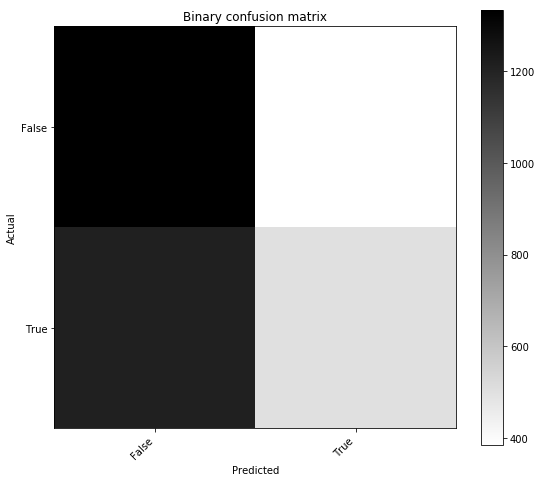

In [737]:
%matplotlib inline
# Confusion Matrix

confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [738]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.49529887199447564


In [739]:
# Error out to stop notebook
for a in i
def 


SyntaxError: invalid syntax (<ipython-input-739-440e5fd394b4>, line 2)

### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# test_set.DiseaseID.nunique()

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    print(col,  df_cd.columns)
    if str(col) in df_cd.columns: print('sd') # df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')

In [ ]:
mem_usage(df_cd)

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
# lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
# del lst
# test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # memory intensive
# for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
#     if col in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
#     if col in test_set.columns: test_set[col] = test_set[col].astype('category')

test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
type(df_cd.ChemicalID[1])

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions']].to_csv('predictions.csv', index=False)

In [ ]:
test_set.head()

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

In [ ]:
test_set.head()

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similarity

In [ ]:
# df1.head()

In [ ]:
# # Calculate out the cosine similarity and see if there's a difference between groups
# def cosine_sim (row):
#     return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

# df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# # Compare cosine sim of correlated and uncorrelated groups
# print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
# print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)